In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = yf.download('AAPL', start='2015-01-01', end='2023-12-31')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [15]:
df.head(15)

Price,Close,High,Low,Open,Volume,MA10,MA50
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,
Date,,,,,,,
2015-03-16,27.904791,27.904791,27.440271,27.665830,143497200,28.089930,26.677913
2015-03-17,28.371550,28.434081,28.061124,28.116956,204092400,28.038118,26.758935
2015-03-18,28.690908,28.845005,28.221921,28.362616,261083600,28.036555,26.860047
2015-03-19,28.474277,28.865101,28.451945,28.753437,183238000,28.060898,26.956783
2015-03-20,28.116961,28.675278,27.951698,28.641780,274780400,28.045265,27.039743
2015-03-23,28.409515,28.552445,28.255419,28.389417,150838800,28.046828,27.110135
2015-03-24,28.293390,28.594881,28.264357,28.413987,131369200,28.095515,27.177671
2015-03-25,27.554167,28.322415,27.554167,28.259883,206620800,28.120975,27.242702


Preprocessing (with more features)

In [3]:
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['Volume'] = df['Volume']

df.dropna(inplace=True)

features = ['Close', 'MA10', 'MA50', 'Volume']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [4]:
sequence_length = 100
x, y = [], []

for i in range(sequence_length, len(scaled_data)):
    x.append(scaled_data[i-sequence_length:i])
    y.append(scaled_data[i, 0])  # Target = Close price

x, y = np.array(x), np.array(y)

In [8]:
split = int(0.8 * len(x))
x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

In [9]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,617 (467.25 KB)

 Trainable params: 119,617 (467.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.fit(x, y, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - loss: 0.0139 - val_loss: 0.0035
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.0019 - val_loss: 0.0042
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - loss: 0.0016 - val_loss: 0.0118
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - loss: 0.0013 - val_loss: 0.0045
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 9.1286e-04 - val_loss: 0.0014
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - loss: 7.7575e-04 - val_loss: 0.0013
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - loss: 7.7199e-04 - val_loss: 0.0023
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
predicted_all = model.predict(x_test)

# Inverse scale both predicted and actual values
# for multiple features, we pad zeros to match scaler input shape
predicted_all_full = np.concatenate([predicted_all, np.zeros((len(predicted_all), x.shape[2] - 1))], axis=1)
y_test_full = np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), x.shape[2] - 1))], axis=1)

predicted_prices = scaler.inverse_transform(predicted_all_full)[:, 0]
actual_prices = scaler.inverse_transform(y_test_full)[:, 0]

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step


In [13]:
comparison_df = pd.DataFrame({
    'Actual Price': actual_prices,
    'Predicted Price': predicted_prices
})

print(comparison_df)

     Actual Price  Predicted Price
0      154.299820       154.659515
1      154.073456       153.762419
2      161.030762       152.744719
3      155.136261       152.240129
4      155.441284       151.635758
..            ...              ...
418    192.444595       179.118807
419    191.897858       178.831566
420    191.997269       178.436223
421    192.424698       178.032286
422    191.380966       177.693967

[423 rows x 2 columns]


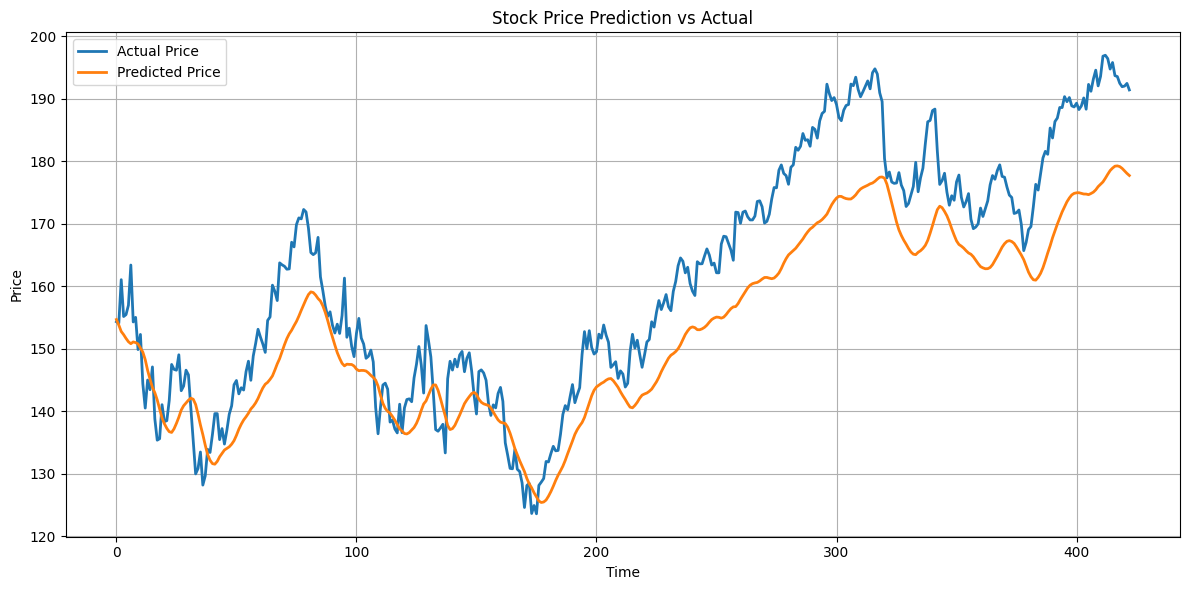

In [14]:
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual Price', linewidth=2)
plt.plot(predicted_prices, label='Predicted Price', linewidth=2)
plt.title('Stock Price Prediction vs Actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()